In [14]:
import numpy as np
import pcs as pcs
import matplotlib.pyplot as plt
from nepc import nepc
from nepc.methods.mp import mp as mp
from nepc.methods.thomson import thomson as thomson
from nepc.util.constants import N2_DIATOMIC_CONSTANTS
from nepc.util.constants import MU_NITROGEN_KG
from nepc.util.constants import WAVENUMBER_PER_EV as WAVENUMBER_PER_EV
from numpy import exp

# Plot psi_v, v=10

In [2]:
N2_DIATOMIC_CONSTANTS.keys()

dict_keys(['N2(X1Sigmag+)', 'N2(A3Sigmau+)', 'N2(B3Pig)', 'N2(W3Deltau)', 'N2(Bp3Sigmau-)', 'N2(ap1Sigmau-)', 'N2(a1Pig)', 'N2(w1Deltau)', 'N2(C3Piu)', 'N2+(X2Sigmag+)', 'N2+(A2Piu)', 'N2+(B2Sigmau+)', 'N2+(C2Sigmau+)'])

In [4]:
r_array_X, psi_X, V_r_X = thomson.psi_v(vp=10,
                                diatomic_constants_p=N2_DIATOMIC_CONSTANTS['N2(X1Sigmag+)'],
                                reduced_mass=MU_NITROGEN_KG,
                                k=17,
                                delta_r=.5,
                                dbug=False)

In [11]:
def Vr_array(Vr_p, r_array):
    return ((mp.Te(Vr_p['To'], Vr_p['we'], Vr_p['wexe']) + 
             Vr_p['De']*(1.0 - exp(-Vr_p['a']*(r_array - Vr_p['re'])))**2 )/WAVENUMBER_PER_EV)

In [15]:
V_r_X_array = Vr_array(V_r_X, r_array_X)

In [16]:
Tv_X_10 = mp.Tv(10, V_r_X['To'], V_r_X['we'], V_r_X['wexe'])/WAVENUMBER_PER_EV

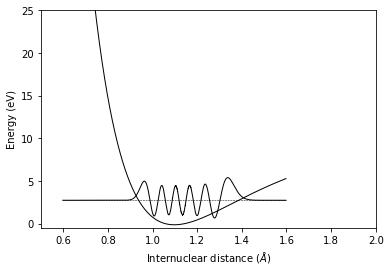

In [24]:
fig,  ax1 = plt.subplots(1)
ax1.plot(r_array_X, V_r_X_array, 'black',
         r_array_X, psi_X + Tv_X_10, 'black', lw=1)
ax1.plot([r_array_X[0], r_array_X[-1]], [Tv_X_10,Tv_X_10], 'black', ls='--', lw=.5)
ax1.set_xlim(.5, 2.0)
ax1.set_ylim(-0.5, 25)
ax1.set_ylabel('Energy (eV)')
ax1.set_xlabel('Internuclear distance ($\AA$)')
plt.show()

# Compute Overlap Matrix and Check for Identity

In [25]:
overlap_X = thomson.fcf_v(vp_max=10, vpp_max=10,
                          diatomic_constants_p=N2_DIATOMIC_CONSTANTS['N2(X1Sigmag+)'],
                          diatomic_constants_pp=N2_DIATOMIC_CONSTANTS['N2(X1Sigmag+)'],
                          reduced_mass=MU_NITROGEN_KG,
                          k=17,
                          delta_r=.5,
                          dbug=False)

In [40]:
thomson.rmse_diagonal_elements(np.asarray(overlap_X))

4.115975731347987e-07

In [41]:
thomson.incremental_rmse_diagonal_elements(np.asarray(overlap_X))

i: 1; rmse: 1.2434497875801753e-14
i: 2; rmse: 5.844456963317449e-14
i: 3; rmse: 8.705960933385516e-14
i: 4; rmse: 1.3228087202133447e-13
i: 5; rmse: 8.627418902497996e-12
i: 6; rmse: 2.070143500535053e-11
i: 7; rmse: 7.328131216053268e-10
i: 8; rmse: 2.783541706933249e-09
i: 9; rmse: 4.101190684672122e-08
i: 10; rmse: 2.1820593021132868e-07
i: 11; rmse: 4.115975731347987e-07


In [42]:
thomson.rmse_off_diagonal_elements(np.asarray(overlap_X))

6.141968809344218e-09

In [43]:
thomson.incremental_rmse_off_diagonal_elements(np.asarray(overlap_X))

i: 2; rmse: 2.074522339725268e-25
i: 3; rmse: 7.195835259280646e-24
i: 4; rmse: 1.4098713900934806e-21
i: 5; rmse: 5.293946037032414e-20
i: 6; rmse: 1.3997529058531574e-17
i: 7; rmse: 1.2512783765787558e-15
i: 8; rmse: 3.9874670519521434e-15
i: 9; rmse: 2.0832281798712301e-13
i: 10; rmse: 5.172134397905407e-11
i: 11; rmse: 6.141968809344218e-09


# Closure relationship for FCF
If the FCF sum over vpp for a given vp are greater than 0.99, that's were we'll stop including cross sections

TODO: we need to determine v'' for closure for all combinations of p' and p'' for v'=0-10.

In [4]:
max_vpp = []
for pp in np.arange(3):
    sum_fcf = 0
    vpp = -1
    while sum_fcf < 0.99:
        vpp += 1
        sum_fcf += fcf[0][pp][0][0][0][vpp]
    print('pp: {}; vpp: {}; sum_fcf = {} > 0.99'.format(pp, vpp, sum_fcf))
    max_vpp.append(vpp)

pp: 0; vpp: 1; sum_fcf = 0.9968899044142606 > 0.99
pp: 1; vpp: 5; sum_fcf = 0.9938864563071671 > 0.99
pp: 2; vpp: 1; sum_fcf = 0.9961254039105287 > 0.99


In [5]:
max_vpp

[1, 5, 1]